https://github.com/napwhale/radarock/blob/main/basic.m

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

plt.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

In [18]:
T = 1e-6;                                                             # % pulse width
B = 100e6;                                                            # % bandwidth
k = B/T;                                                              # % LFM tuning slope
fs = 2*B;                                                             # % sampling frequency
dt = 1/fs;                                                            # % sampling interval

PRF = 2e3;
PRI = 1/PRF;
CPI = 1.5/60;
Nprf = math.ceil(CPI/PRI);

c = 3e8;
fc = 3e9;                                                             # % carrier frequency
lamda = c/fc;                                                         # % wavelength
Rmax = 19*c*T/2;                                                      # % maximum range (19 times of the pulse width)
Vmax = (lamda*PRF/2)/2;                                               # % maximum velocity (half of the PRF as the maximum doppler shift)
Ntgt = 3;                                                             # % number of targets
R = Rmax*np.random.normal(size = Ntgt);
V = Vmax*(2*np.random.normal(size = Ntgt)-1);
Tc = 20*T;                                                            # % sampling duration in one PRI
Nc = math.ceil(Tc/dt);                                                     # % number of samples
print( Nc)
print( len(R))
print( len(V))

4000
3
3


200


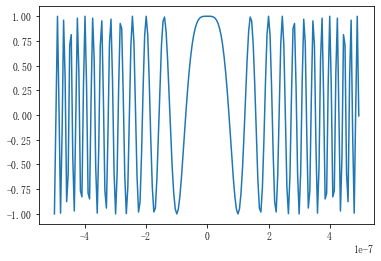

In [19]:
t = np.arange(-T/2,T/2,dt)
lfm = np.exp(1j*np.pi*k*np.square(t))
plt.figure();
plt.plot(t, np.real(lfm));
print( len(t))

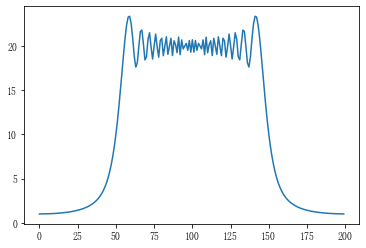

In [20]:
plt.figure();
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(lfm))));

In [21]:
#%% Sending Signal
tt = np.arange(-T/2 ,Tc-T/2,dt)                                           # % time axis for one PRI, including the pulse at the head
lt = np.where(np.abs(tt)<T/2,1,0)
print(len(lt))

4000


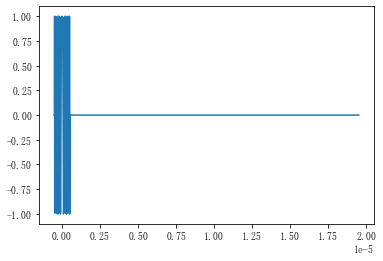

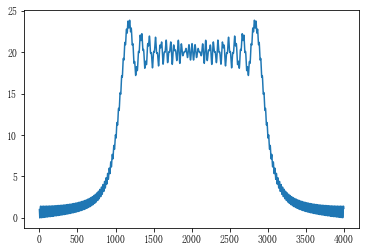

In [22]:
lfm_send = lt * np.exp(1j*np.pi*k*np.square(tt));                        
plt.figure();
plt.plot(tt, np.real(lfm_send));
plt.figure();
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(lfm_send))));

In [23]:
#%% Receiving Signal
lfm_cpi = np.zeros([Nprf, Nc]);
for i in range(Nprf):
    td = i*PRI;
    lfm_prf = 0;
    for j in range(Ntgt):
        r = R[j];
        v = V[j];
        tau = 2*(r - v*(td+tt))/c;                                     #% time delay
        lt = np.where(np.abs(tt)<T/2,1,0)
        lfm_rcv = lt * np.exp(-1j*2*np.pi*fc*tau + 1j*np.pi*k*np.square(tt-tau));
        lfm_prf = lfm_prf + lfm_rcv;
    lfm_cpi[i, :] = lfm_prf;

d:\anaconda3\envs\stock\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


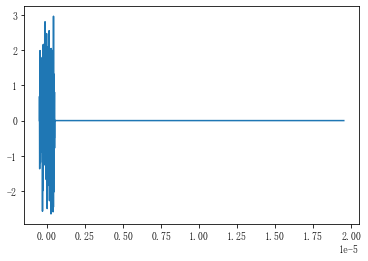

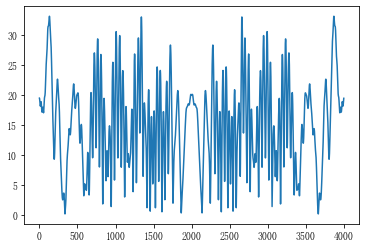

In [24]:
plt.figure();
plt.plot(tt, np.real(lfm_cpi[0, :]));
plt.figure();
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(lfm_cpi[0, :]))));

In [34]:
#%% Noise
noise = 0.5*np.random.normal(size=(Nprf, len(tt)));
signal = lfm_cpi + noise;
print( signal )
x = (tt+T/2)*c/2                                                    #% fast time axis
y = np.arange(1,Nprf+1)                                             #% slow time axis
print(y)
y = y*PRI

[[ 0.15045828  0.7801179  -0.34834562 ...  0.21384983  0.11772172
  -0.28065517]
 [ 0.07421439  0.58173443  0.34310446 ... -0.50164004  0.45062685
  -0.7724442 ]
 [ 0.22594251  0.74875343  1.69029114 ... -1.32405174  0.56599882
   0.65146194]
 ...
 [ 0.02627489  2.75227233 -0.10172167 ...  0.34727237  0.41898684
  -0.31111958]
 [ 0.77502302  2.71356249  1.47908339 ...  0.10763013 -0.41949765
  -1.09994201]
 [ 0.4241161   1.94155836  1.85789686 ... -0.2150015  -0.22680598
  -0.10168948]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


(4000,)
(50,)
(50, 4000)
(50, 4000)
(50, 4000)


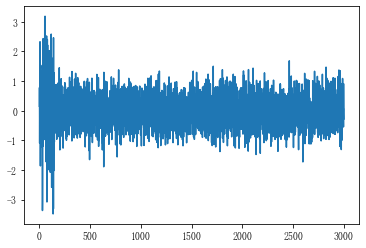

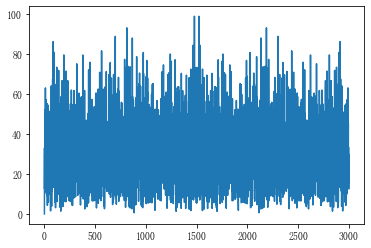

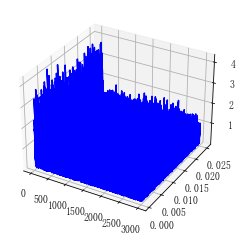

In [38]:
plt.figure();
plt.plot(x, np.real(signal[0, :]));
plt.figure();
plt.plot(x, np.abs(np.fft.fftshift(np.fft.fft(signal[0, :]))));

fig = plt.figure();
ax = fig.add_subplot(111, projection='3d')
print( x.shape)
print( y.shape)
X, Y = np.meshgrid(x, y)
#plt.mesh(x, y, abs(signal));plt.view(0,90);
#ax.plot_surface(X, Y, np.abs(signal))
print( X.shape)
print( Y.shape)
print( signal.shape)
ax.plot_wireframe(X, Y, np.abs(signal), color='blue')
plt.show()

d:\anaconda3\envs\stock\lib\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


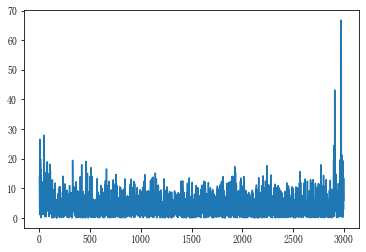

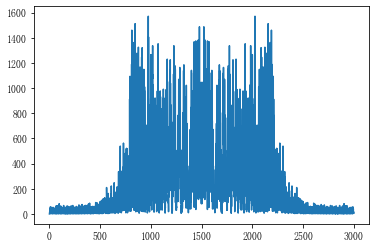

In [40]:
#%% Pulse Compression
hw = lfm_send;
HW = np.conj(np.fft.fft(hw, Nc));
signal_cp = np.zeros([Nprf, Nc]);
for i in range(Nprf):
    signal_cp[i, :] = np.fft.ifft(np.fft.fft(signal[i, :], Nc) * HW);


plt.figure();
plt.plot(x, np.abs(signal_cp[0, :]));
plt.figure();
plt.plot(x,np.abs(np.fft.fftshift(np.fft.fft(signal_cp[0, :]))));



(4000,)
(50,)
(50, 4000)
(50, 4000)
(50, 4000)


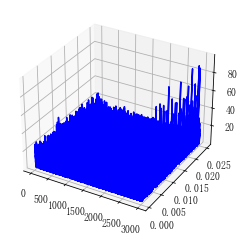

In [44]:

zs = np.abs(signal_cp)
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d')
print( x.shape)
print( y.shape)
X, Y = np.meshgrid(x, y)
#plt.mesh(x, y, abs(signal));plt.view(0,90);
#ax.plot_surface(X, Y, np.abs(signal))
print( X.shape)
print( Y.shape)
print( signal.shape)
ax.plot_wireframe(X, Y, np.abs(signal_cp), color='blue')
plt.show()

In [47]:
#%% MTD
hm = np.hamming(Nprf)
print(hm.shape)

(50,)


(50, 4000)
(50, 4000)
(4000,)
(50,)
(50, 4000)
(50, 4000)
(50, 4000)


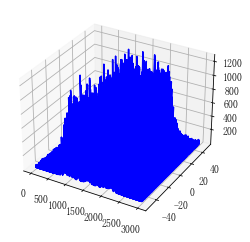

In [59]:
#win = np.matlab.repmat(hamming(Nprf), 1, Nc);
win = np.tile(hm,(1,Nc)).reshape(Nprf,Nc)

print( signal_cp.shape )
print( win.shape )
signal_mtd = np.fft.fftshift(np.fft.fft(signal_cp*win))
y = np.arange( -Vmax,Vmax,2*Vmax/Nprf )
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d')
print( x.shape)
print( y.shape)
X, Y = np.meshgrid(x, y)
#plt.mesh(x, y, abs(signal));plt.view(0,90);
#ax.plot_surface(X, Y, np.abs(signal))
print( X.shape)
print( Y.shape)
print( signal.shape)
ax.plot_wireframe(X, Y, np.abs(signal_mtd), color='blue')
plt.show()